# Project: Predicting the Maintenance Needs of Trees in NYC

Data Source: https://data.cityofnewyork.us/Environment/2015-Street-Tree-Census-Tree-Data/uvpi-gqnh

### Problem Statement:
* The NYC Parks and Recreation department has requested a predictive model to support the team responsible for the maintenance of municipal trees. The workers cannot attend to every tree in 'fair' or 'poor' health throughout the city, but they are hoping to maximize their efficiency by only scheduling maintenance work for the minority of trees that are not already in 'good' health. 

### Key Metric:
* Precision of the minority class (minimizing false positives)

### Methods:
Class weighting to address imbalance:
* The target variable (health) was very imbalanced, with the majority of trees being in 'good' health and a minority of trees being in 'fair' or 'poor' health. Given the problem statement, both minority classes were combined to frame the project as binary classification: predicting if a tree will require maintenance or not. Undersampling the majority class/oversampling the minority was considered but rejected; while both potentially increased overall accuracy and to some extent recall, the key metric (precision of the minority class) decreased with the loss of information in undersampling and the creation of synthetic information in oversampling. Instead, cost-sensitive learning algorithms with adjustable class weighting were selected (Decision Tree and Random Forest classifiers) to balance class weights.

Hyperparameter tuning for the key metric:
* Given the class imbalance, both models were overfit to the majority class. Hyperparameter tuning was done 1) manually to reduce overfitting to the data, and 2) through both random search cross validation and grid search cross validation to maximize the precision of the minority class. Consequently, the model scores were expected to generally be lower (given the limited minority data) than if an averaged or weighted metric (which factors in majority class classification) has been selected. Precision of the minority class increased through hyperparameter tuning, but overfitting continued to be an issue.

### Model Performance:
* Key metric (precision of the minority class): 61%
* Overall accuracy: 83%


In [1]:
#imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, make_scorer, precision_score

## Data Wrangling

In [2]:
#load data
data = pd.read_csv('tree.csv')

In [3]:
#check load
data.head()

,tree_id,block_id,created_at,tree_dbh,stump_diam,curb_loc,status,health,spc_latin,spc_common,...,boro_ct,state,latitude,longitude,x_sp,y_sp,council district,census tract,bin,bbl
0,180683,348711,08/27/2015,3,0,OnCurb,Alive,Fair,Acer rubrum,red maple,...,4073900,New York,40.723092,-73.844215,1027431.148,202756.7687,29.0,739.0,4052307.0,4.022210e+09
1,200540,315986,09/03/2015,21,0,OnCurb,Alive,Fair,Quercus palustris,pin oak,...,4097300,New York,40.794111,-73.818679,1034455.701,228644.8374,19.0,973.0,4101931.0,4.044750e+09
2,204026,218365,09/05/2015,3,0,OnCurb,Alive,Good,Gleditsia triacanthos var. inermis,honeylocust,...,3044900,New York,40.717581,-73.936608,1001822.831,200716.8913,34.0,449.0,3338310.0,3.028870e+09
3,204337,217969,09/05/2015,10,0,OnCurb,Alive,Good,Gleditsia triacanthos var. inermis,honeylocust,...,3044900,New York,40.713537,-73.934456,1002420.358,199244.2531,34.0,449.0,3338342.0,3.029250e+09
4,189565,223043,08/30/2015,21,0,OnCurb,Alive,Good,Tilia americana,American linden,...,3016500,New York,40.666778,-73.975979,990913.775,182202.4260,39.0,165.0,3025654.0,3.010850e+09


In [4]:
# Set tree_id as index
data = data.set_index('tree_id')

In [5]:
# Check info
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 683788 entries, 180683 to 200607
Data columns (total 44 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   block_id          683788 non-null  int64  
 1   created_at        683788 non-null  object 
 2   tree_dbh          683788 non-null  int64  
 3   stump_diam        683788 non-null  int64  
 4   curb_loc          683788 non-null  object 
 5   status            683788 non-null  object 
 6   health            652172 non-null  object 
 7   spc_latin         652169 non-null  object 
 8   spc_common        652169 non-null  object 
 9   steward           652173 non-null  object 
 10  guards            652172 non-null  object 
 11  sidewalk          652172 non-null  object 
 12  user_type         683788 non-null  object 
 13  problems          652124 non-null  object 
 14  root_stone        683788 non-null  object 
 15  root_grate        683788 non-null  object 
 16  root_other     

* Some columns are irrelevant to model prediction based on the data dictionary (created_at, user_type) and can be dropped
* Spc_latin is a duplicate of spc_common. Common will be kept
* Geographic columns overlap significantly and all but latitude and longitude can be dropped (block_id, address, postcode, zip_city, state, x_sp, y_sp) 
* Community/neighborhood defining colums also overlap significantly and all but borough can be dropped (community board, borocode, boro_ct, cncldist, st_assem, st_senate, nta, nta_name, council district, bin, bbl, census tract)
* Problems is a concatenation of other problem columns

In [6]:
#drop columns
df = data.drop(columns=['created_at', 'user_type', 'spc_latin','block_id', 'address', 'postcode', 'zip_city', 'state', 'x_sp', 'y_sp','community board', 'borocode', 'boro_ct', 'cncldist', 'st_assem', 'st_senate', 'nta','nta_name', 'council district', 'bin', 'bbl', 'census tract', 'problems'], axis=1)

In [7]:
#check for duplicates
df.duplicated().sum()

89

In [8]:
#drop duplicates
df = df.drop_duplicates()

In [9]:
# check percentage of null values
null = df.isnull().sum().sort_values(ascending=False)
print(null[null>0]/len(df)*100)

spc_common    4.623672
health        4.623233
guards        4.623233
sidewalk      4.623233
steward       4.623087
dtype: float64


* There are several missing values for the target variable, 'health' which will have to be dropped

In [10]:
#drop null 'health' records
df = df.dropna(subset=['health'])

In [11]:
#recheck null values after dropping null target variable records
null = df.isnull().sum().sort_values(ascending=False)
print(null[null>0]/len(df)*100)

spc_common    0.000767
guards        0.000153
sidewalk      0.000153
dtype: float64


* The remaining null values are neglible and can be dropped

In [12]:
#drop remaining null records
df = df.dropna()

## Exploratory Data Analysis

### Target Variable

In [13]:
#check class distribution of the target variable
print(df.health.value_counts(normalize=True))

Good    0.810889
Fair    0.147986
Poor    0.041125
Name: health, dtype: float64


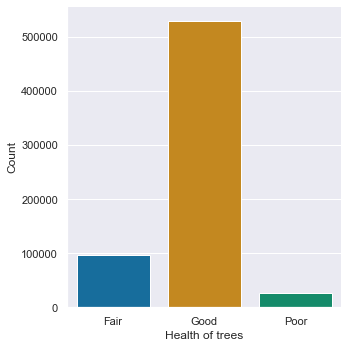

In [14]:
#plot distribution
sns.set(style='darkgrid', palette='colorblind')
sns.catplot(x='health', kind='count', data=df)
plt.xlabel('Health of trees')
plt.ylabel('Count')
plt.show()

* Very imbalanced classes
* Majority of trees are in 'good' health
* Very few trees are in 'fair' or 'poor' health

In [15]:
#create new binary target variable for whether a tree require maintenance
#drop multiclass variable 'health'
df['maintenance'] = df.health.apply(lambda x: False if x == 'Good' else True)
df.drop('health', inplace=True, axis=1)

In [16]:
#check data types
df.dtypes

tree_dbh         int64
stump_diam       int64
curb_loc        object
status          object
spc_common      object
steward         object
guards          object
sidewalk        object
root_stone      object
root_grate      object
root_other      object
trunk_wire      object
trnk_light      object
trnk_other      object
brch_light      object
brch_shoe       object
brch_other      object
borough         object
latitude       float64
longitude      float64
maintenance       bool
dtype: object

### Numeric Variables


In [17]:
#check numeric variables
df.select_dtypes(['int','float']).describe()

,tree_dbh,stump_diam,latitude,longitude
count,652084.000000,652084.0,652084.000000,652084.000000
mean,11.710286,0.0,40.700994,-73.924592
std,8.634282,0.0,0.090270,0.123840
min,0.000000,0.0,40.498466,-74.254965
25%,5.000000,0.0,40.631724,-73.980972
50%,10.000000,0.0,40.700297,-73.913452
75%,16.000000,0.0,40.762002,-73.835242
max,425.000000,0.0,40.912918,-73.700488


In [18]:
#check stump_diam values
df.stump_diam.value_counts()

0    652084
Name: stump_diam, dtype: int64

* All stump_diam values are zero and the column can be dropped

In [19]:
#drop stump_diam column
df.drop('stump_diam', inplace=True, axis=1)

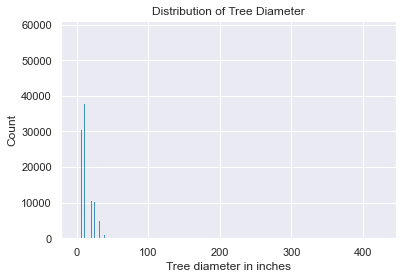

In [20]:
#check tree_dbh distribution
sns.histplot(x='tree_dbh', data=df)
plt.title('Distribution of Tree Diameter')
plt.xlabel('Tree diameter in inches')
plt.ylabel('Count')
plt.show()

* Distribution has a long tail
* Check tail for potential outliers

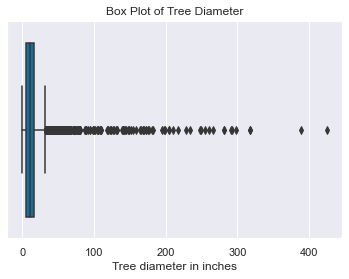

In [21]:
#check tree_dbh
sns.boxplot(x='tree_dbh', data=df)
plt.title('Box Plot of Tree Diameter')
plt.xlabel('Tree diameter in inches')
plt.show()

* Many outliers in the upper range (beyond plausibility for the actual size of trees, likely the result of data misentry by the volunteers)
* Filter out the top 5% of values

In [22]:
#filter top 5% of tree_dbh
df = df[df.tree_dbh < df.tree_dbh.quantile(0.95)]

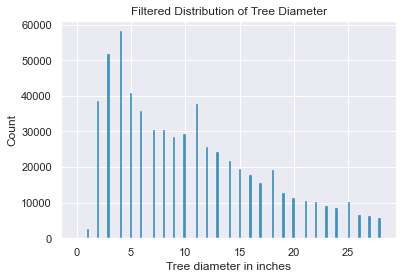

In [23]:
#re-check tree_dbh distribution
sns.histplot(x='tree_dbh', data=df)
plt.title('Filtered Distribution of Tree Diameter')
plt.xlabel('Tree diameter in inches')
plt.ylabel('Count')
plt.show()

* Distribution is not normal but outliers have been removed

### Categorical Variables

In [24]:
#check other variables
df.select_dtypes('object').describe()

,curb_loc,status,spc_common,steward,guards,sidewalk,root_stone,root_grate,root_other,trunk_wire,trnk_light,trnk_other,brch_light,brch_shoe,brch_other,borough
count,618474,618474,618474,618474,618474,618474,618474,618474,618474,618474,618474,618474,618474,618474,618474,618474
unique,2,1,132,4,4,2,2,2,2,2,2,2,2,2,2,5
top,OnCurb,Alive,London planetree,None,None,NoDamage,No,No,No,No,No,No,No,No,No,Queens
freq,594526,618474,68948,457145,539697,447166,494838,614963,590447,606570,617460,587761,561769,618078,594967,220592


* Status column only has one unique value and can be dropped
* The remaining object type columns look to be categorical and can be converted to category type to save memory

In [25]:
#drop status column
df = df.drop('status', axis=1)

In [26]:
#convert to category type
cat = df.select_dtypes('object').columns
df[cat] = df[cat].astype('category')

In [27]:
#explore most common tree species
df.spc_common.value_counts().head(5)

London planetree    68948
honeylocust         64147
Callery pear        58876
pin oak             46199
Norway maple        33663
Name: spc_common, dtype: int64

In [28]:
#explore most rare tree species
df.spc_common.value_counts().tail(5)

black pine       36
pitch pine       30
Osage-orange     28
Scots pine       25
Virginia pine    10
Name: spc_common, dtype: int64

In [29]:
#number of unique species
df.spc_common.nunique()

132

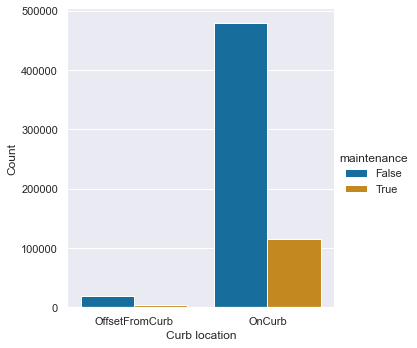

In [30]:
#check curb location
df.curb_loc.value_counts()
sns.catplot(x='curb_loc', kind='count', data=df, hue='maintenance')
plt.xlabel('Curb location')
plt.ylabel('Count')
plt.show()

* Imbalanced category
* No visible difference between maintenance

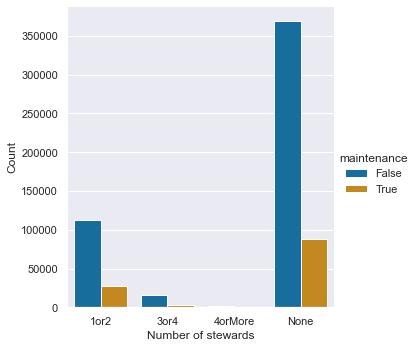

In [31]:
#check number of stewards
df.steward.value_counts()
sns.catplot(x='steward', kind='count', data=df, hue='maintenance')
plt.xlabel('Number of stewards')
plt.ylabel('Count')
plt.show()

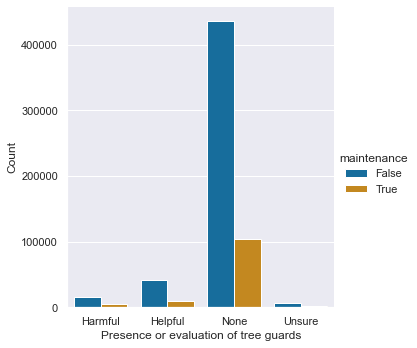

In [32]:
#check guards
df.guards.value_counts()
sns.catplot(x='guards', kind='count', data=df, hue='maintenance')
plt.xlabel('Presence or evaluation of tree guards')
plt.ylabel('Count')
plt.show()

In [33]:
#check sidewalk 
df.sidewalk.value_counts()

NoDamage    447166
Damage      171308
Name: sidewalk, dtype: int64

In [34]:
#check boroughs
df.borough.value_counts()

Queens           220592
Brooklyn         160592
Staten Island     97136
Bronx             78194
Manhattan         61960
Name: borough, dtype: int64

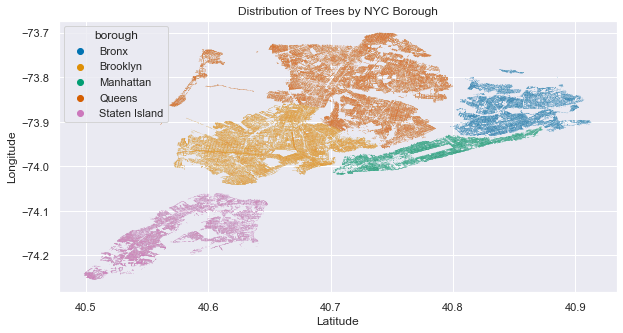

In [35]:
#check latitude and longitude
#approximate map by plotting boroughs
plt.figure(figsize = (10, 5))
sns.scatterplot(x='latitude', y='longitude', data=df, s=0.05, hue='borough')
plt.title('Distribution of Trees by NYC Borough')
plt.xlabel('Latitude')
plt.ylabel('Longitude')
plt.show()

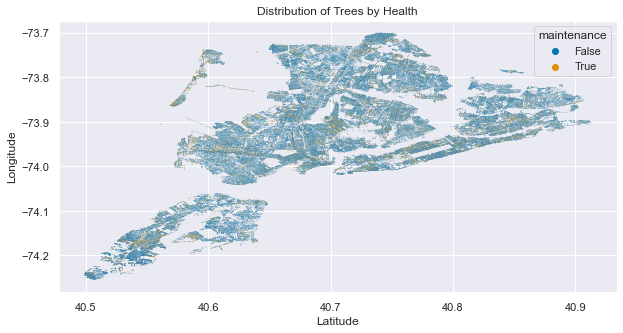

In [36]:
#check geographical distribution of tree health 
plt.figure(figsize = (10, 5))
sns.scatterplot(x='latitude', y='longitude', data=df, s=0.05, hue='maintenance')
plt.title('Distribution of Trees by Health')
plt.xlabel('Latitude')
plt.ylabel('Longitude')
plt.show()

* Overall, no significant visible difference between the trees requiring maintenance VS not discovered through the exploratory data analysis
* Many categorical variables seem imbalanced toward the 'None' categories
* While tree health may have small areas of concentration, on the whole, both healthy and unhealthy trees seem spread out throughout the entire city

## Preprocessing

In [37]:
#define variables
y = df.maintenance
X = df.drop('maintenance', axis=1)

### Split train and test sets

In [38]:
#split training and testing data
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.33, random_state=14)

In [39]:
#check shape
print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

(414377, 18) (204097, 18)
(414377,) (204097,)


In [40]:
#define columns
numeric = ['tree_dbh', 'latitude', 'longitude']
categorical = X_train.select_dtypes('category').columns

In [41]:
#create processor
processor = ColumnTransformer(transformers=[
    ('number', StandardScaler(), numeric),
    ('category', OneHotEncoder(handle_unknown='ignore'), categorical)
])
#fit/transform train set and transform test set to prevent data leakage
X_train = processor.fit_transform(X_train)
X_test = processor.transform(X_test)

## Modeling

### Decision Tree Classifier

In [42]:
#instantiate decision tree classifier with balanced class weights to address imbalance
dtc = DecisionTreeClassifier(class_weight='balanced')

#fit and predict
dtc.fit(X_train, y_train)
dtc_train_pred = dtc.predict(X_train)
dtc_test_pred = dtc.predict(X_test)

#check all metrics
dtc_train_report = classification_report(y_train, dtc_train_pred)
dtc_test_report = classification_report(y_test, dtc_test_pred)
print('dtc train classification report:')
print(dtc_train_report)
print('dtc test classification report:')
print(dtc_test_report)

dtc train classification report:
              precision    recall  f1-score   support

       False       1.00      1.00      1.00    334118
        True       1.00      1.00      1.00     80259

    accuracy                           1.00    414377
   macro avg       1.00      1.00      1.00    414377
weighted avg       1.00      1.00      1.00    414377

dtc test classification report:
              precision    recall  f1-score   support

       False       0.86      0.86      0.86    164567
        True       0.41      0.42      0.41     39530

    accuracy                           0.77    204097
   macro avg       0.64      0.64      0.64    204097
weighted avg       0.77      0.77      0.77    204097



In [43]:
#get tree depth
dtc.get_depth()

79

* DTC model is very overfit overall to the training data
* Precision of positive class (key metric) is 0.41

### Random Forest Classifier

In [44]:
#create random forest classifier with balanced class weights to address imbalance
rfc = RandomForestClassifier(class_weight='balanced', random_state=14, n_jobs=-1)

In [45]:
#fit and predict
rfc.fit(X_train, y_train)
rfc_train_pred = rfc.predict(X_train)
rfc_test_pred = rfc.predict(X_test)

In [46]:
#check all metrics
rfc_train_report = classification_report(y_train, rfc_train_pred)
rfc_test_report = classification_report(y_test, rfc_test_pred)
print('training classification report:')
print(rfc_train_report)
print('testing classification report:')
print(rfc_test_report)

training classification report:
              precision    recall  f1-score   support

       False       1.00      1.00      1.00    334118
        True       1.00      1.00      1.00     80259

    accuracy                           1.00    414377
   macro avg       1.00      1.00      1.00    414377
weighted avg       1.00      1.00      1.00    414377

testing classification report:
              precision    recall  f1-score   support

       False       0.85      0.95      0.90    164567
        True       0.58      0.28      0.38     39530

    accuracy                           0.82    204097
   macro avg       0.71      0.62      0.64    204097
weighted avg       0.79      0.82      0.80    204097



* RFC model is also overfit to the training data
* However, precision of the positive class (key metric) is 0.58 (higher than DTC)

In [47]:
#address overfitting by limiting max depth
rfc_dep = RandomForestClassifier(class_weight='balanced', random_state=14, n_jobs=-1, max_depth=50)
rfc_dep.fit(X_train, y_train)
rfc_dep_train_pred = rfc_dep.predict(X_train)
rfc_dep_test_pred = rfc_dep.predict(X_test)

In [48]:
#recheck reports
rfc_dep_train_report = classification_report(y_train, rfc_dep_train_pred)
rfc_dep_test_report = classification_report(y_test, rfc_dep_test_pred)
print('training classification report:')
print(rfc_dep_train_report)
print('testing classification report:')
print(rfc_dep_test_report)

training classification report:
              precision    recall  f1-score   support

       False       0.99      1.00      0.99    334118
        True       1.00      0.95      0.97     80259

    accuracy                           0.99    414377
   macro avg       0.99      0.98      0.98    414377
weighted avg       0.99      0.99      0.99    414377

testing classification report:
              precision    recall  f1-score   support

       False       0.85      0.94      0.89    164567
        True       0.56      0.30      0.39     39530

    accuracy                           0.82    204097
   macro avg       0.70      0.62      0.64    204097
weighted avg       0.79      0.82      0.80    204097



* Complete overfitting to the training data has been partially addressed while trying to minimize effect on precision
* Lower max depth will speed up random search/grid search cross validation

#### RandomizedSearchCV

In [49]:
#make scorer for the key metric: precision of the minority class
scorer = make_scorer(precision_score, labels=[1], average=None)

In [50]:
#create param grid for random search
random_param = {
    'n_estimators':[100, 150, 200, 250],
    'max_features':[60, 90, 120]
}

In [53]:
#run a random search to optimize macro precision
rfc_random = RandomizedSearchCV(rfc_dep, param_distributions=random_param, cv=2, scoring=scorer, n_jobs=-1)

In [54]:
#fit grid search
rfc_random.fit(X_train, y_train)

RandomizedSearchCV(cv=2,
                   estimator=RandomForestClassifier(class_weight='balanced',
                                                    max_depth=50, n_jobs=-1,
                                                    random_state=14),
                   n_jobs=-1,
                   param_distributions={'max_features': [60, 90, 120],
                                        'n_estimators': [100, 150, 200, 250]},
                   scoring=make_scorer(precision_score, labels=[1], average=None))

In [55]:
#check best params
rfc_random.best_params_

{'n_estimators': 250, 'max_features': 60}

In [56]:
#check cross validation test scores
rfc_random.cv_results_['mean_test_score']

array([0.59209533, 0.58787629, 0.59241585, 0.58771837, 0.59072649,
       0.58675593, 0.59326293, 0.58869565, 0.59127521, 0.58922389])

In [57]:
#check classification reports
rfc_random_train_report = classification_report(y_train, rfc_random.predict(X_train))
rfc_random_test_report = classification_report(y_test, rfc_random.predict(X_test))
print('training classification report:')
print(rfc_random_train_report)
print('testing classification report:')
print(rfc_random_test_report)

training classification report:
              precision    recall  f1-score   support

       False       1.00      1.00      1.00    334118
        True       1.00      1.00      1.00     80259

    accuracy                           1.00    414377
   macro avg       1.00      1.00      1.00    414377
weighted avg       1.00      1.00      1.00    414377

testing classification report:
              precision    recall  f1-score   support

       False       0.85      0.95      0.90    164567
        True       0.62      0.31      0.41     39530

    accuracy                           0.83    204097
   macro avg       0.73      0.63      0.65    204097
weighted avg       0.81      0.83      0.81    204097



* Model is still very overfit to training data
* Precision of the minority class has increased to 0.62

#### GridSearchCV

In [77]:
#create param grid for grid search
#limit max_depth further
grid_param = {
    'n_estimators':[230, 250],
    'max_features':[70, 80],
    'max_depth':[40]
}

In [78]:
#create grid search using the best estimator from the random search
rfc_grid = GridSearchCV(rfc_random.best_estimator_, param_grid=grid_param, cv=2, scoring=scorer, n_jobs=-1)

In [79]:
#fit grid search
rfc_grid.fit(X_train, y_train)

GridSearchCV(cv=2,
             estimator=RandomForestClassifier(class_weight='balanced',
                                              max_depth=50, max_features=60,
                                              n_estimators=250, n_jobs=-1,
                                              random_state=14),
             n_jobs=-1,
             param_grid={'max_depth': [40], 'max_features': [70, 80],
                         'n_estimators': [230, 250]},
             scoring=make_scorer(precision_score, labels=[1], average=None))

In [80]:
#check best params
rfc_grid.best_params_

{'max_depth': 40, 'max_features': 80, 'n_estimators': 250}

In [81]:
#check test scores
rfc_grid.cv_results_['mean_test_score']

array([0.5833047 , 0.5842728 , 0.58368704, 0.58436681])

In [82]:
#check classification reports
rfc_grid_train_report = classification_report(y_train, rfc_grid.predict(X_train))
rfc_grid_test_report = classification_report(y_test, rfc_grid.predict(X_test))
print('training classification report:')
print(rfc_grid_train_report)
print('testing classification report:')
print(rfc_grid_test_report)

training classification report:
              precision    recall  f1-score   support

       False       1.00      1.00      1.00    334118
        True       1.00      0.99      0.99     80259

    accuracy                           1.00    414377
   macro avg       1.00      1.00      1.00    414377
weighted avg       1.00      1.00      1.00    414377

testing classification report:
              precision    recall  f1-score   support

       False       0.85      0.95      0.90    164567
        True       0.61      0.32      0.42     39530

    accuracy                           0.83    204097
   macro avg       0.73      0.64      0.66    204097
weighted avg       0.81      0.83      0.81    204097



* Model is still overfit to training data, but given the class imbalance, additional depth limitations will likely affect precision
* CV scores have stabilized and further tuning will not likely lead to significant differences
* Weighted averages for other metrics (precision, recall, and f1-score) all above 0.8

In [83]:
#create final model
model = rfc_grid.best_estimator_

In [84]:
#model score
print(precision_score(y_test, model.predict(X_test), labels=[1], average=None))

[0.60971652]


In [88]:
#final model parameters
model.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': 'balanced',
 'criterion': 'gini',
 'max_depth': 40,
 'max_features': 80,
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 250,
 'n_jobs': -1,
 'oob_score': False,
 'random_state': 14,
 'verbose': 0,
 'warm_start': False}

### Conclusions:
* Overall accuracy and weighted metrics were fairly strong on the test set (above 0.8)
* The key metric (precision of the minority class) improved from the Decision Tree Classifier (0.41) to the Random Forest Classifier (0.58) and improved further through hyperparameter tuning (0.61)
* Additionally, given that the trees in NYC are not planted in isolation, workers scheduling maintenance can use the model to find areas with higher concentrations of trees that are likely in 'fair' or 'poor' health
* The final model is still overfit to the training data; to reduce overfitting while maintaining high precision, additional data from the minority class should be collected to 1) balance the data and 2) re-train the model